# Retriving $g_{obs}$

## Setup Script

In [3]:
import mond_project as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pk
import pandas as pd

/home/mlschott343/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Retrieval Code

This code creates a directory called 'halo_saves' which is where it saves all of the data for each halo. This segment should only be run once to retrieve the data. Once it has been run and the files made, you shouldn't have to ever run it again.

In [ ]:
###################################################################################################
# 
# This is setup code for the script. It makes sure that there is a folder for all of the halo files.
# Run Once
# 
###################################################################################################


cwd = os.getcwd()                                            # Sets the working directory
if os.path.exists(os.path.join(cwd,'halo_saves')):           # Checks for 'halo_saves' dir
    break                                                     
else:                                                        
    os.mkdir(os.path.join(cwd,'halo_saves'))                 # If it doesn't exist, creates it
    save_loc = os.path.join(cwd,'halo_saves')                # Sets the save location for
                                                             #   mp.save_halos()
    
mp.save_halos('Illustris-1', save_loc, z=0, snapnum=0)       # Calls mp.save_halos() for redshift 0
                                                             #   and only the first snapshot
    

## Extracting $g_{obs}$

Here we loop through all radii up to a maximum (here set to 50 kpc) with a set bin size (here set to 1 kpc) and add those pandas.dataFrame elements to a list called 'gobs'. This list is then used to find average $g_{obs}$ for the given radius over all 100 galaxies.

In [6]:
###################################################################################################
# 
# This chunk is very slow! This would not be good for a scale-up in object number!
# 
###################################################################################################


gobs = []                                                    # gobs is a list of pandas.DataFrame 
                                                             #   objects, each corresponding to a
                                                             #   different radius (kpc). This is
                                                             #   used for extracting the average
                                                             #   g_obs. The average is calculated
                                                             #   over all 100 objects at a given
                                                             #   radius.
                        
init_r = 5                                                   # Initial Radius (kpc)
final_r = 50                                                 # Final Radius (kpc)
bin_size = 1                                                 # This sets the size of Delta_r (kpc)

for radius in range(init_r, final_r, bin_size):              # Loops though all radii
    
                                                             # This saves each DataFrame element
                                                             #   at radius 'radius' with bin size
                                                             #   of 'bin_size' from all galaxies.
    elem = mp.calc_gobs(radius, bin_size, os.path.join('halo_saves', 'subhalo_list.npz'))
    
    gobs.append(elem)                                        # Appends the element to 'gobs'
    
    print('Finished Radius '+str(radius)+' kpc', end = '\r') # Counter output

print('Done!                                         ')      # 'Done' Flag

                                                             # 'gobs' now contains 
                                                             #   (final_r - init_r)/bin_size elems.
                                                             #   each of which contain the DataFrame
                                                             #   object for each galaxy at that
                                                             #   radius.
                    

Done!                                         


## Calculating Average $g_{obs}$

Here we use 'gobs' to calculate the average $g_{obs}$ at each given radius with bin size 'bin_size'. This is then appended to a dictionary object that has entries of the form { 'radius' : 'average $g_{obs}$ }. It's these values that parameterize our function $g_{obs}(r)$.

In [8]:
id_list = list(gobs[0])                                      # Gets a list of galaxy IDs. These are
                                                             #   not all continuous integers, as
                                                             #   not every ID'ed object in
                                                             #   Illustris-1 is a galaxy.
            

g_obs_r = {}                                                 # The 'radius:g_obs' dictionary

for r in range(init_r, final_r, bin_size):                   # Iterating through radii
    
    galaxy_list = []                                         # 'galaxy_list' contains the values of
                                                             #    g_obs for each galaxy at radius r
        
    for id in id_list:                                       # Iterating though each ID
        galaxy_list.append(gobs[r-init_r].at[r,id])          # Adding the g_obs value of galaxy
                                                             #   'id' to the list 'galaxy_list'
        
    g_obs_r[r] = galaxy_list                                 # Appending 'galaxy_list' to g_obs_r

avg_gobs = {}                                                # Dictionary of average g_obs values
                                                             #   for each radius. Radii are the
                                                             #   keys and average g_obs are the
                                                             #   values.
            
for r in range(init_r, final_r, bin_size):                   # Calculating average and adding it
                                                             #   to the dictionary. There are 
                                                             #   occasionally 'nan' entries in the
                                                             #   data, which is why the numpy
                                                             #   functions are being used.
    
    avg_gobs[r] = np.nansum(g_obs_r[r])/(len(g_obs_r[r]) - np.count_nonzero(np.isnan(g_obs_r[r])))


## Plotting $g_{obs}$ vs $r$

We want to confirm that our curve takes the right form, so we'll do a quick plot to check it.

/home/mlschott343/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


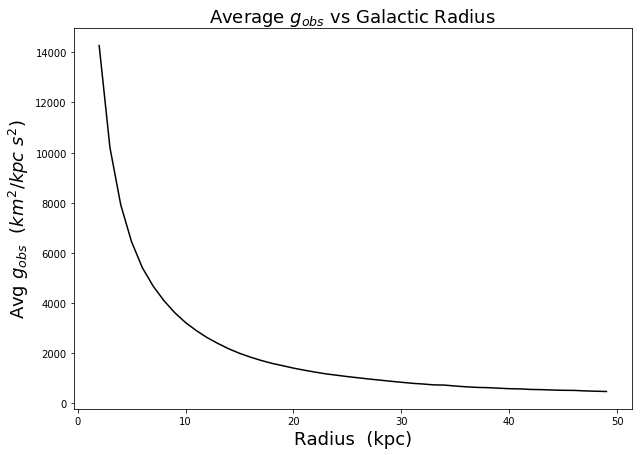

In [15]:
# conversion = (3.24078*10**-34)/(3.17098*10**-16)           # g_obs is currently km^2*s^-2*kpc^-1. 
                                                             #   This converts to kpc/s^2.
    ## This Element not currrently used!

x = range(init_r, final_r, bin_size)                         # Gets the range of radii for plotting
y = [x for x in avg_gobs.values()]                           # Add '*conversion' to x to add 
                                                             #   conversion and store it as a list.

font_size = 18                                               # Declare 'font_size' variable

fig = plt.figure(1,figsize = (10,7))                         # All of the below is plotting. See
plt.plot(x,y,'black')                                        #   matplotlib.pyplot documentation
ax = plt.axes()                                              #   for additional details!
ax.set_xlabel('Radius  (kpc)', fontsize = font_size)
ax.set_ylabel('Avg $g_{obs}$  ($km^2/kpc \ s^2$)', fontsize = font_size)
ax.set_title('Average $g_{obs}$ vs Galactic Radius', fontsize = font_size)

plt.savefig('avg_gobs_v_rad.png')                            # Saves the plot
